In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna
import pickle
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

/Users/danielzellner/Documents/Studium/Bachelorthesis/venv_global/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_pickle('df_neutor_features.pkl')
df

,Datum,Zeit,Wochentag,Neutor (gesamt),Feiertag,Semesterferien,Ferien,Lockdown,Verkehr_vor_einer_Woche,Verkehrs_Differenz,Neutor_FR_stadtauswärts_vor_einer_Woche,Neutor_FR_stadteinwärts_vor_einer_Woche,Neutor_FR_stadtauswärts_Differenz,Neutor_FR_stadteinwärts_Differenz,Top4_letzte_Woche,Berufsverkehr,Jahreszeit
0,2018-01-01,00:00:00,Montag,71.0,1,1,1,0,71.0,0.0,45.0,26.0,0.0,0.0,False,False,Winter
1,2018-01-01,01:00:00,Montag,67.0,1,1,1,0,67.0,0.0,32.0,35.0,0.0,0.0,False,False,Winter
2,2018-01-01,02:00:00,Montag,123.0,1,1,1,0,123.0,0.0,70.0,53.0,0.0,0.0,False,False,Winter
3,2018-01-01,03:00:00,Montag,171.0,1,1,1,0,171.0,0.0,107.0,64.0,0.0,0.0,False,False,Winter
4,2018-01-01,04:00:00,Montag,102.0,1,1,1,0,102.0,0.0,76.0,26.0,0.0,0.0,False,False,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43816,2022-12-31,18:00:00,Samstag,365.0,0,1,1,0,100.0,265.0,69.0,31.0,123.0,142.0,False,True,Winter
43817,2022-12-31,19:00:00,Samstag,303.0,0,1,1,0,61.0,242.0,37.0,24.0,102.0,140.0,False,False,Winter
43818,2022-12-31,20:00:00,Samstag,207.0,0,1,1,0,43.0,164.0,18.0,25.0,87.0,77.0,False,False,Winter
43819,2022-12-31,21:00:00,Samstag,149.0,0,1,1,0,36.0,113.0,17.0,19.0,49.0,64.0,False,False,Winter


### Daten vorbereiten

In [3]:
df.columns

Index(['Datum', 'Zeit', 'Wochentag', 'Neutor (gesamt)', 'Feiertag',
       'Semesterferien', 'Ferien', 'Lockdown', 'Verkehr_vor_einer_Woche',
       'Verkehrs_Differenz', 'Neutor_FR_stadtauswärts_vor_einer_Woche',
       'Neutor_FR_stadteinwärts_vor_einer_Woche',
       'Neutor_FR_stadtauswärts_Differenz',
       'Neutor_FR_stadteinwärts_Differenz', 'Top4_letzte_Woche',
       'Berufsverkehr', 'Jahreszeit'],
      dtype='object')

In [4]:
df['Jahr'] = df['Datum'].dt.year
df['Monat'] = df['Datum'].dt.month
df['Tag'] = df['Datum'].dt.day

In [11]:
df['Zeit'] = df['Zeit'].astype(str)
df['Stunde'] = df['Zeit'].str.split(':').str[0].astype(int)

In [6]:
df = pd.concat([df, pd.get_dummies(df['Wochentag'], prefix='Wochentag')], axis=1)

In [21]:
df = pd.concat([df, pd.get_dummies(df['Jahreszeit'], prefix='Jahreszeit')], axis=1)

In [7]:
df['Berufsverkehr'] = df['Berufsverkehr'].astype(int)

In [22]:
df.columns

Index(['Datum', 'Zeit', 'Wochentag', 'Neutor (gesamt)', 'Feiertag',
       'Semesterferien', 'Ferien', 'Lockdown', 'Verkehr_vor_einer_Woche',
       'Verkehrs_Differenz', 'Neutor_FR_stadtauswärts_vor_einer_Woche',
       'Neutor_FR_stadteinwärts_vor_einer_Woche',
       'Neutor_FR_stadtauswärts_Differenz',
       'Neutor_FR_stadteinwärts_Differenz', 'Top4_letzte_Woche',
       'Berufsverkehr', 'Jahreszeit', 'Jahr', 'Monat', 'Tag',
       'Wochentag_Dienstag', 'Wochentag_Donnerstag', 'Wochentag_Freitag',
       'Wochentag_Mittwoch', 'Wochentag_Montag', 'Wochentag_Samstag',
       'Wochentag_Sonntag', 'Stunde', 'Jahreszeit_Frühling',
       'Jahreszeit_Herbst', 'Jahreszeit_Sommer', 'Jahreszeit_Winter'],
      dtype='object')

In [25]:
features = ['Feiertag','Semesterferien', 'Ferien', 'Lockdown', 'Verkehr_vor_einer_Woche',
            'Verkehrs_Differenz', 'Neutor_FR_stadtauswärts_vor_einer_Woche',
            'Neutor_FR_stadteinwärts_vor_einer_Woche',
            'Neutor_FR_stadtauswärts_Differenz',
            'Neutor_FR_stadteinwärts_Differenz', 'Top4_letzte_Woche',
            'Berufsverkehr', 'Jahr', 'Monat', 'Tag',
            'Wochentag_Dienstag', 'Wochentag_Donnerstag', 'Wochentag_Freitag',
            'Wochentag_Mittwoch', 'Wochentag_Montag', 'Wochentag_Samstag',
            'Wochentag_Sonntag', 'Stunde', 'Jahreszeit_Frühling',
            'Jahreszeit_Herbst', 'Jahreszeit_Sommer', 'Jahreszeit_Winter']
target = 'Neutor (gesamt)'

# Gesamtdatenmenge
data_size = len(df)

# Aufteilung in Trainings-, Validierungs- und Testsets
train_size = int(data_size * 0.7)  # 70% Training
test_size = int(data_size * 0.2)   # 20% Test
val_size = data_size - train_size - test_size  # Rest für die Validierung

# Trainingsdaten
X_train = df[features].iloc[:train_size]
y_train = df[target].iloc[:train_size]

# Validierungsdaten
X_val = df[features].iloc[train_size:train_size+val_size]
y_val = df[target].iloc[train_size:train_size+val_size]

# Testdaten
X_test = df[features].iloc[train_size+val_size:]
y_test = df[target].iloc[train_size+val_size:]

In [26]:
print(X_train.dtypes)

Feiertag                                     int64
Semesterferien                               int64
Ferien                                       int64
Lockdown                                     int64
Verkehr_vor_einer_Woche                    float64
Verkehrs_Differenz                         float64
Neutor_FR_stadtauswärts_vor_einer_Woche    float64
Neutor_FR_stadteinwärts_vor_einer_Woche    float64
Neutor_FR_stadtauswärts_Differenz          float64
Neutor_FR_stadteinwärts_Differenz          float64
Top4_letzte_Woche                             bool
Berufsverkehr                                int64
Jahr                                         int32
Monat                                        int32
Tag                                          int32
Wochentag_Dienstag                            bool
Wochentag_Donnerstag                          bool
Wochentag_Freitag                             bool
Wochentag_Mittwoch                            bool
Wochentag_Montag               

In [27]:
# Random Forest
def objective_rf(trial):
    # Hyperparameter, die optimiert werden sollen
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 20)
    #max_features = trial.suggest_categorical('max_features', [0.2, 0.4, 0.6, 0.8])
    
    # Modell erstellen
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                  #max_features=max_features ,
                                  random_state=42)
    model.fit(X_train, y_train)
    
    # Vorhersagen
    preds = model.predict(X_val)
    
    # MAE auf dem Validierungsdatensatz
    return mean_absolute_error(y_val, preds)

# XGBoost
def objective_xgb(trial):
    # Hyperparameter, die optimiert werden sollen
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 20)
    #learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

    # Modell erstellen
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                             #learning_rate=learning_rate, 
                             random_state=42)
    model.fit(X_train, y_train)

    # Vorhersagen
    preds = model.predict(X_val)

    # MAE auf dem Validierungsdatensatz
    return mean_absolute_error(y_val, preds)

# Optuna-Studien erstellen
study_rf = optuna.create_study(direction="minimize")
study_xgb = optuna.create_study(direction="minimize")

# Hyperparameter-Optimierung für Random Forest
study_rf.optimize(objective_rf, n_trials=40)
best_params_rf = study_rf.best_params

# Hyperparameter-Optimierung für XGBoost
study_xgb.optimize(objective_xgb, n_trials=40)
best_params_xgb = study_xgb.best_params

# Beste Modelle mit besten Hyperparametern trainieren
best_model_rf = RandomForestRegressor(**best_params_rf, random_state=42)
best_model_rf.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

best_model_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42)
best_model_xgb.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Vorhersagen und MAE mit dem Testdatensatz berechnen
best_preds_rf = best_model_rf.predict(X_test)
best_mae_rf = mean_absolute_error(y_test, best_preds_rf)

best_preds_xgb = best_model_xgb.predict(X_test)
best_mae_xgb = mean_absolute_error(y_test, best_preds_xgb)

# Ergebnisse anzeigen
print("Best Random Forest Parameters:", best_params_rf)
print("Best Random Forest MAE:", best_mae_rf)

print("\nBest XGBoost Parameters:", best_params_xgb)
print("Best XGBoost MAE:", best_mae_xgb)

[I 2023-09-06 15:50:50,727] A new study created in memory with name: no-name-960278fb-51c2-4e9d-937b-2edfb7cc03e5
[I 2023-09-06 15:50:50,732] A new study created in memory with name: no-name-79c3edfc-d444-4834-b63c-5bf2b8a08f6a
[I 2023-09-06 15:51:04,856] Trial 0 finished with value: 3.430087181772609 and parameters: {'n_estimators': 85, 'max_depth': 17}. Best is trial 0 with value: 3.430087181772609.
[I 2023-09-06 15:51:34,159] Trial 1 finished with value: 3.4249946688869857 and parameters: {'n_estimators': 192, 'max_depth': 15}. Best is trial 1 with value: 3.4249946688869857.
[I 2023-09-06 15:51:53,082] Trial 2 finished with value: 3.3541572111297695 and parameters: {'n_estimators': 117, 'max_depth': 16}. Best is trial 2 with value: 3.3541572111297695.
[I 2023-09-06 15:52:24,750] Trial 3 finished with value: 3.443653214999404 and parameters: {'n_estimators': 190, 'max_depth': 19}. Best is trial 2 with value: 3.3541572111297695.
[I 2023-09-06 15:52:44,394] Trial 4 finished with value:

Best Random Forest Parameters: {'n_estimators': 76, 'max_depth': 16}
Best Random Forest MAE: 2.265148908324022

Best XGBoost Parameters: {'n_estimators': 50, 'max_depth': 15}
Best XGBoost MAE: 4.3153988512417545


In [28]:
best_model_rf = RandomForestRegressor(**best_params_rf, random_state=42)
best_model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, n_estimators=76, random_state=42)

#### Model speichern

In [29]:
with open('best_random_forest_model_without_weather.pkl', 'wb') as rf_model_file:
    pickle.dump(best_model_rf, rf_model_file)

In [30]:
best_model_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42)
best_model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

#### Model speichern

In [31]:
with open('best_xgboost_model_without_weather.pkl', 'wb') as xgb_model_file:
    pickle.dump(best_model_xgb, xgb_model_file)

In [32]:
print("Best Random Forest Parameters:", best_params_rf)
print("Best XGBoost Parameters:", best_params_xgb)

Best Random Forest Parameters: {'n_estimators': 76, 'max_depth': 16}
Best XGBoost Parameters: {'n_estimators': 50, 'max_depth': 15}


### Entscheidungsbaum ploten

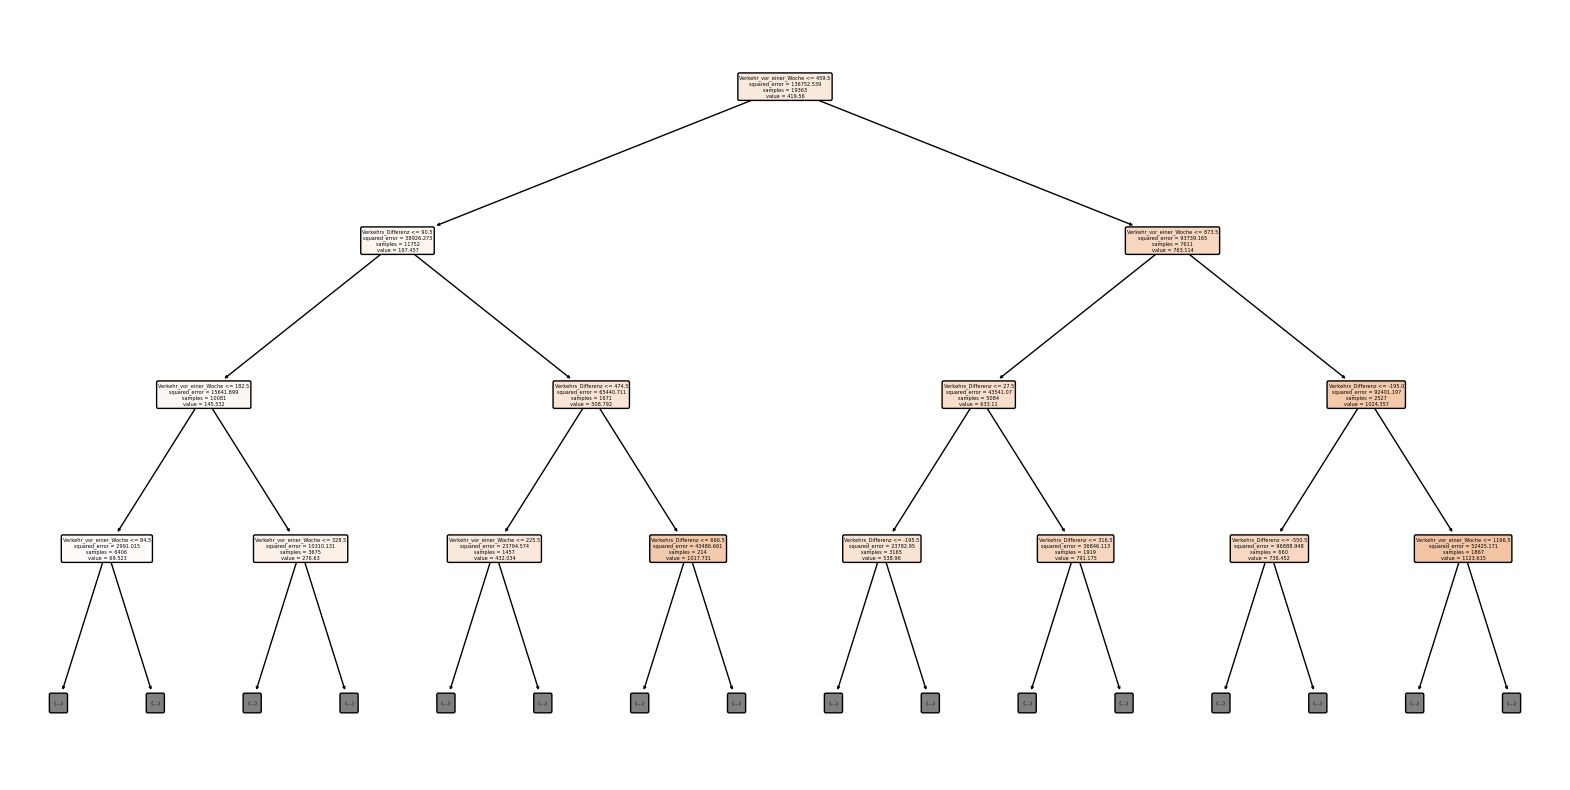

In [40]:
single_tree = best_model_rf.estimators_[2] # Baum x
plt.figure(figsize=(20, 10))
plot_tree(single_tree, feature_names=features, filled=True, rounded=True, max_depth=3)
plt.savefig("visualization/random_forest_tree_2.png", dpi=300)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.393097 to fit


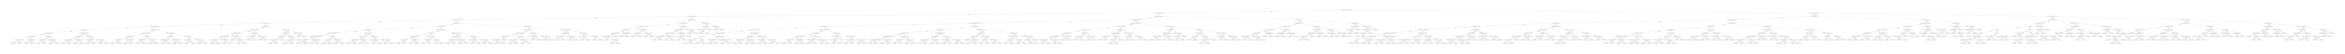

In [41]:
booster = best_model_xgb.get_booster()

fig, ax = plt.subplots(figsize=(30, 20))

xgb.plot_tree(booster, num_trees=2, ax=ax)  # Baum auswaehlen
plt.show()

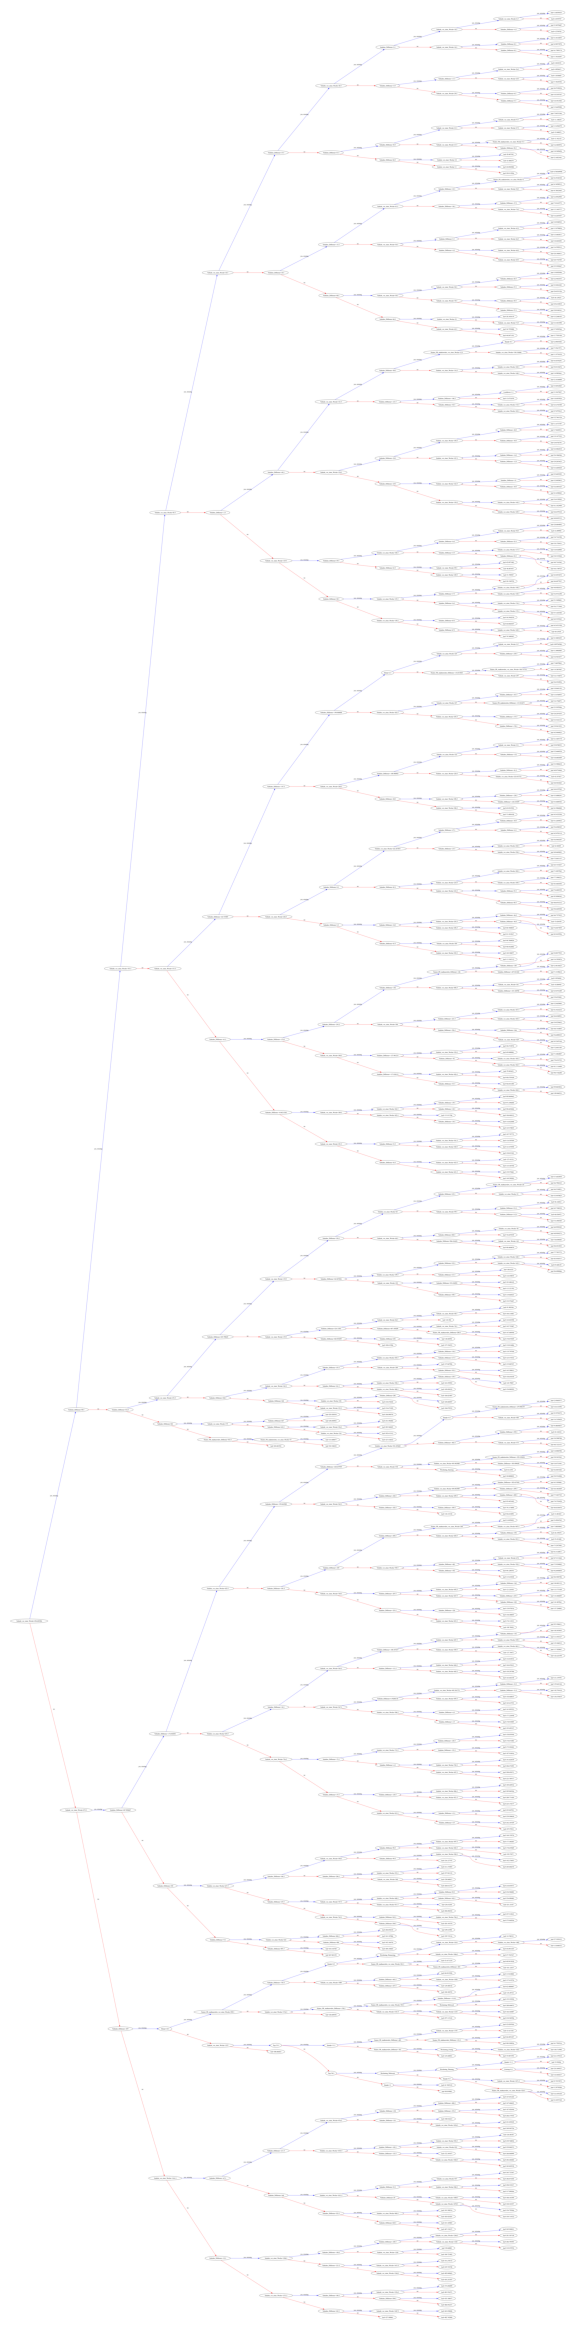

In [42]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(best_model_xgb, num_trees=0, ax=ax, rankdir='LR')
plt.show()

### Overfitting test

In [34]:
train_preds_rf = best_model_rf.predict(X_train)
train_mae_rf = mean_absolute_error(y_train, train_preds_rf)

val_preds_rf = best_model_rf.predict(X_val)
val_mae_rf = mean_absolute_error(y_val, val_preds_rf)

print(f"Random Forest - Train MAE: {train_mae_rf}, Validation MAE: {val_mae_rf}")

Random Forest - Train MAE: 1.101551369534593, Validation MAE: 3.3257402096069004


In [35]:
train_preds_xgb = best_model_xgb.predict(X_train)
train_mae_xgb = mean_absolute_error(y_train, train_preds_xgb)

val_preds_xgb = best_model_xgb.predict(X_val)
val_mae_xgb = mean_absolute_error(y_val, val_preds_xgb)

print(f"XGBoost - Train MAE: {train_mae_xgb}, Validation MAE: {val_mae_xgb}")

XGBoost - Train MAE: 0.4575585434647327, Validation MAE: 4.667347254630342


### XGBoost könnte overfitting vorliegen, deswegen wird der Baum begrenzt

In [36]:
def objective_xgb(trial):
    # Hyperparameter, die optimiert werden sollen
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    lambda_ = trial.suggest_float('lambda', 0.0, 1.0)

    # Modell erstellen
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                             reg_lambda=lambda_, random_state=42)
    model.fit(X_train, y_train)

    # Vorhersagen
    preds = model.predict(X_val)

    # MAE auf dem Validierungsdatensatz
    return mean_absolute_error(y_val, preds)

# Optuna-Studie für XGBoost erstellen
study_xgb = optuna.create_study(direction="minimize")

# Hyperparameter-Optimierung für XGBoost
study_xgb.optimize(objective_xgb, n_trials=40)
best_params_xgb = study_xgb.best_params

# Bestes Modell mit besten Hyperparametern trainieren
best_model_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42)
best_model_xgb.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Vorhersagen und MAE mit dem Testdatensatz berechnen
best_preds_xgb = best_model_xgb.predict(X_test)
best_mae_xgb = mean_absolute_error(y_test, best_preds_xgb)

# Ergebnisse anzeigen
print("Best XGBoost Parameters:", best_params_xgb)
print("Best XGBoost MAE:", best_mae_xgb)

[I 2023-09-06 16:07:02,874] A new study created in memory with name: no-name-fa0c2a42-6122-4609-a805-310115466ecf
[I 2023-09-06 16:07:07,262] Trial 0 finished with value: 5.519339936811575 and parameters: {'n_estimators': 240, 'max_depth': 7, 'lambda': 0.9096661386953228}. Best is trial 0 with value: 5.519339936811575.
[I 2023-09-06 16:07:08,210] Trial 1 finished with value: 9.967365663634945 and parameters: {'n_estimators': 84, 'max_depth': 4, 'lambda': 0.8051413118359669}. Best is trial 0 with value: 5.519339936811575.
[I 2023-09-06 16:07:10,931] Trial 2 finished with value: 5.3588243515162155 and parameters: {'n_estimators': 105, 'max_depth': 9, 'lambda': 0.5936110801102522}. Best is trial 2 with value: 5.3588243515162155.
[I 2023-09-06 16:07:14,099] Trial 3 finished with value: 5.039562673254391 and parameters: {'n_estimators': 145, 'max_depth': 8, 'lambda': 0.012163332625625634}. Best is trial 3 with value: 5.039562673254391.
[I 2023-09-06 16:07:22,445] Trial 4 finished with value

Best XGBoost Parameters: {'n_estimators': 197, 'max_depth': 10, 'lambda': 0.18341083806020708}
Best XGBoost MAE: 4.078625481708024


In [37]:
train_preds_xgb = best_model_xgb.predict(X_train)
train_mae_xgb = mean_absolute_error(y_train, train_preds_xgb)

val_preds_xgb = best_model_xgb.predict(X_val)
val_mae_xgb = mean_absolute_error(y_val, val_preds_xgb)

print(f"XGBoost - Train MAE: {train_mae_xgb}, Validation MAE: {val_mae_xgb}")

XGBoost - Train MAE: 0.3887579275812589, Validation MAE: 0.3176378670725813


### Neues Modell speichern

In [38]:
with open('best_xgboost_model_without_weather.pkl', 'wb') as xgb_model_file:
    pickle.dump(best_model_xgb, xgb_model_file)